In [1]:
!pip install sktime --ignore-installed

     |████████████████████████████████| 17.0 MB 5.8 MB/s            
     |████████████████████████████████| 53 kB 1.2 MB/s             
     |████████████████████████████████| 24.8 MB 25.4 MB/s            
     |████████████████████████████████| 15.7 MB 32.3 MB/s            
     |████████████████████████████████| 119 kB 56.9 MB/s            
     |████████████████████████████████| 11.3 MB 54.8 MB/s            
     |████████████████████████████████| 38.1 MB 21.9 MB/s            
     |████████████████████████████████| 77 kB 4.3 MB/s             
     |████████████████████████████████| 502 kB 43.6 MB/s            
     |████████████████████████████████| 247 kB 58.5 MB/s            
     |████████████████████████████████| 302 kB 43.1 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21

In [2]:
import random
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import sktime
from sktime.transformations.panel.rocket import Rocket
import lightgbm as lgbm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


# Load data

In [3]:
df = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
tot_sequence = len(df.sequence.unique())
tot_subject = len(df.subject.unique())
print(f'We have {tot_sequence} sequences and {tot_subject} subjects.')

df.set_index(['sequence', 'subject'], drop=False, inplace=True)
df.drop('step', axis=1, inplace=True)
df.head()

We have 25968 sequences and 672 subjects.


sequence  subject  sensor_00  sensor_01  sensor_02  \
sequence subject                                                       
0        47              0       47  -0.196291   0.112395        1.0   
         47              0       47  -0.447450   0.134454        1.0   
         47              0       47   0.326893  -0.694328        1.0   
         47              0       47   0.523184   0.751050        1.0   
         47              0       47   0.272025   1.074580        1.0   

                  sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  \
sequence subject                                                          
0        47        0.329204  -1.004660  -0.131638  -0.127505   0.368702   
         47       -0.658407   0.162495   0.340314  -0.209472  -0.867176   
         47        0.330088   0.473678   1.280479  -0.094718   0.535878   
         47        0.976991  -0.563287  -0.720269   0.793260   0.951145   
         47       -0.136283   0.398579   0.044877   0.560109  -0.541985   

                  sensor_08  sensor_09  sensor_10  sensor_11  sensor_12  
sequence subject                                                         
0        47            -0.1  -0.963873  -0.985069   0.531893   4.751492  
         47             0.2  -0.301301   0.082733  -0.231481   0.454390  
         47             1.4   1.002168   0.449221  -0.586420  -4.736147  
         47            -0.3  -0.995665  -0.434290   1.344650   0.429241  
         47            -0.9   1.055636   0.812631   0.123457  -0.223359

In [4]:
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/test.csv')
tot_sequence_test = len(df_test.sequence.unique())
print(f'We have {tot_sequence_test} sequences and {len(df_test.subject.unique())} subjects.')

df_test.set_index(['sequence', 'subject'], drop=False, inplace=True)
df_test.drop('step', axis=1, inplace=True)
df_test.head()

We have 12218 sequences and 319 subjects.


sequence  subject  sensor_00  sensor_01  sensor_02  \
sequence subject                                                       
25968    684         25968      684   2.427357  19.639706        1.0   
         684         25968      684  -4.950541 -21.747899        1.0   
         684         25968      684   1.136012 -10.756303        1.0   
         684         25968      684   0.806028   6.504202        1.0   
         684         25968      684   1.288253   5.552521        1.0   

                  sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  \
sequence subject                                                          
25968    684      -1.466372  -1.289973  -4.207928   2.486339  -2.493893   
         684       0.983186  -0.569053   1.845924  -3.887978   1.727481   
         684       1.016814   0.964157   2.454749   0.312386   1.154198   
         684      -0.179646   0.969221  -1.035153  -0.457195   0.254962   
         684      -0.493805  -1.036124  -1.126402   2.008197  -0.730534   

                  sensor_08  sensor_09  sensor_10  sensor_11  sensor_12  
sequence subject                                                         
25968    684            8.0  -1.123555  -1.673048  10.980453   0.419011  
         684           -2.9   0.395231  -0.882233  -1.871399  -0.008525  
         684           -5.6   1.114162   1.525273 -11.584362   0.139812  
         684           -2.7  -0.588873   0.608761  -4.241770  -0.462916  
         684            0.0   0.899566  -1.259615  -0.472222  -0.121483

In [5]:
# all sequence has complete 60 seconds time step
complete = []
for a in range(tot_sequence):
    if df.loc[a].shape[0] == 60:
        complete.append(a)
len(complete)

25968

In [6]:
df_label = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
df_label.head(10)

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


# Turn `df` into a 3D matrix

In [7]:
df.drop(['sequence', 'subject'], axis=1, inplace=True)
df_test.drop(['sequence', 'subject'], axis=1, inplace=True)

In [8]:
print(df.shape[1] == df_test.shape[1])

def get_3D(data, total_seq):
    # sktime requires the 3D data to be (total sequence, total variables, n_timepoints)
    new_data = np.zeros((total_seq, 13, 60))
    for i in range(total_seq):
        new_data[i] = data.loc[i].T
    return new_data

def get_3D_test(data, total_seq):
    new_data = np.zeros((total_seq, 13, 60))
    for i in range(total_seq):
        # in test dataset, the index starts 25968, which is
        # the total sequence (tot_sequence) in the train dataset.
        new_data[i] = data.loc[i + tot_sequence].T
    return new_data

True


In [9]:
df_3d = get_3D(df, tot_sequence)
df_test_3d = get_3D_test(df_test, tot_sequence_test)

In [10]:
print(df_3d.shape)
print(df_test_3d.shape)

(25968, 13, 60)
(12218, 13, 60)


# Visualization

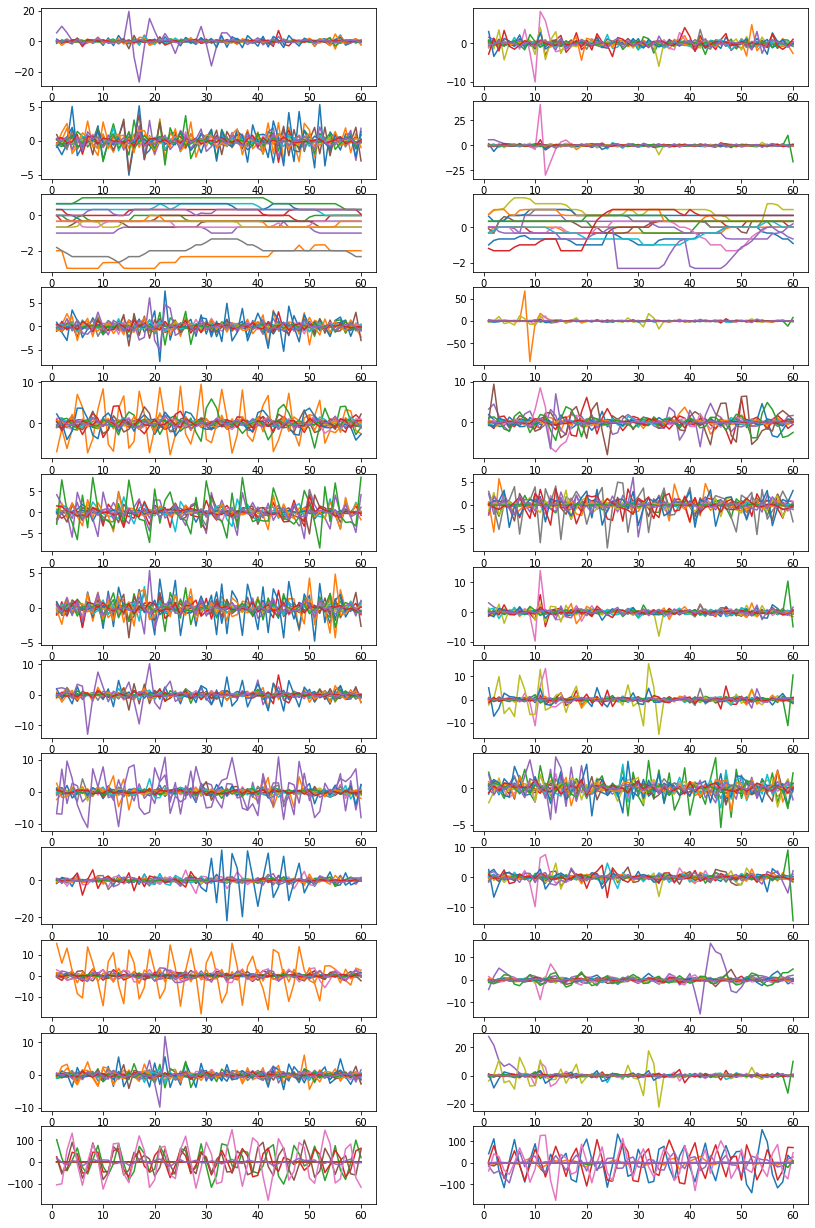

In [11]:
rnd = np.random.default_rng()

state0 = df_3d[df_label.state==0]
state1 = df_3d[df_label.state==1]

fig = plt.figure(figsize=(12, 22))
sfigs = fig.subfigures(1, 2)
axsL = sfigs[0].subplots(13, 1)
axsR = sfigs[1].subplots(13, 1)

for ts in range(15):
    # choose a sequence
    seq = rnd.choice(state0.shape[0])
    
    for censor in range(13):
        # plot each sensor from the sequence
        axsL[censor].plot(np.arange(1, 61), state0[seq, censor, :])
        
for ts in range(15):
    # choose a sequence
    seq = rnd.choice(state1.shape[0])
    
    for censor in range(13):
        # plot each sensor from the sequence
        axsR[censor].plot(np.arange(1, 61), state1[seq, censor, :])

# Split the dataset into train and valid

In [12]:
rnd = np.random.default_rng(8)
trainid = rnd.choice(tot_sequence, replace=False, size=int(0.8*tot_sequence))
validid = [i for i in list(range(tot_sequence)) if i not in trainid]

In [13]:
# the sequences are splitted perfectly into 2 groups
set(trainid).intersection(set(validid))

set()

In [14]:
train_X = df_3d[trainid, :]
valid_X = df_3d[validid, :]

train_y = df_label.loc[trainid, 'state']
valid_y = df_label.loc[validid, 'state']

In [15]:
train_X.shape

(20774, 13, 60)

# ROCKET transformation

In [16]:
trans = Rocket(n_jobs=-1, random_state=8)

trans.fit(train_X, train_y)

Rocket(n_jobs=-1, random_state=8)

In [17]:
train_X = trans.transform(train_X)
valid_X = trans.transform(valid_X)
test_X = trans.transform(df_test_3d)

In [18]:
train_X.shape

(20774, 20000)

In [19]:
valid_X.shape

(5194, 20000)

# Modeling

In [20]:
lgbm_mod = lgbm.LGBMClassifier(n_estimators=2500, num_leaves=35, min_child_samples=150,
                               reg_lambda=0.1, colsample_bytree=0.9, random_state=8, n_jobs=-1)
lgbm_mod.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], eval_metric='AUC')

[1]	valid_0's auc: 0.828528	valid_0's binary_logloss: 0.659177
[2]	valid_0's auc: 0.84602	valid_0's binary_logloss: 0.631907
[3]	valid_0's auc: 0.857324	valid_0's binary_logloss: 0.608021
[4]	valid_0's auc: 0.862141	valid_0's binary_logloss: 0.587105
[5]	valid_0's auc: 0.86545	valid_0's binary_logloss: 0.569337
[6]	valid_0's auc: 0.870004	valid_0's binary_logloss: 0.552827
[7]	valid_0's auc: 0.872127	valid_0's binary_logloss: 0.538731
[8]	valid_0's auc: 0.875167	valid_0's binary_logloss: 0.525292
[9]	valid_0's auc: 0.87804	valid_0's binary_logloss: 0.513351
[10]	valid_0's auc: 0.878598	valid_0's binary_logloss: 0.503699
[11]	valid_0's auc: 0.879036	valid_0's binary_logloss: 0.495029
[12]	valid_0's auc: 0.8817	valid_0's binary_logloss: 0.485748
[13]	valid_0's auc: 0.882997	valid_0's binary_logloss: 0.478153
[14]	valid_0's auc: 0.883814	valid_0's binary_logloss: 0.471522
[15]	valid_0's auc: 0.885454	valid_0's binary_logloss: 0.464947
[16]	valid_0's auc: 0.887191	valid_0's binary_logloss:

LGBMClassifier(colsample_bytree=0.9, min_child_samples=150, n_estimators=2500,
               num_leaves=35, random_state=8, reg_lambda=0.1)

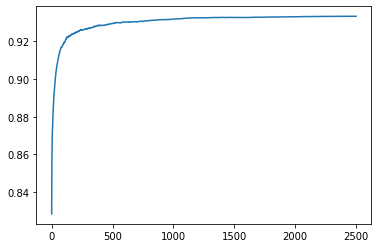

In [21]:
plt.plot(lgbm_mod.evals_result_['valid_0']['auc']);

# Submission

In [22]:
subs = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv')
subs.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [23]:
subs['state'] = lgbm_mod.predict_proba(test_X)[:, 1]
subs.head()

,sequence,state
0,25968,9.511354e-01
1,25969,9.798179e-01
2,25970,5.225775e-10
3,25971,8.131767e-01
4,25972,7.782881e-01


In [24]:
subs.to_csv('my_submission.csv', index=False)